In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset_contour import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from torchvision.transforms import GaussianBlur
# from hybrid_model_v1 import HybridSegModel
from hybrid_model_v3_contour import HybridSegModel_contour
from helper import save_2x2_comparison

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
# wandb.login()

In [4]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):

    p = 0.5
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness=0.5)
    #     image = jitter(image)
    # if(random.random() < p):
    #     angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
    #     translate = (random.uniform(-0.05, 0.05) * image.size[0],
    #                  random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
    #     scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
    #     shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
    #     image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
    #     mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    # if random.random() < p:
    #     image = F.hflip(image)
    #     mask = F.hflip(mask)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

image, mask, contour, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [5]:
seg_type

tensor([2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2,
        1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2,
        1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 2, 1, 1])

In [6]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))
print("unique : ", torch.unique(contour))

std :  tensor(1.0000)
unique :  tensor([0., 1.])
unique :  tensor([0., 1.])


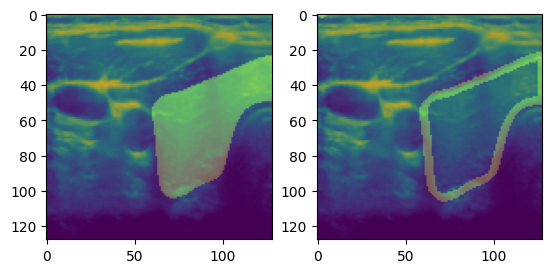

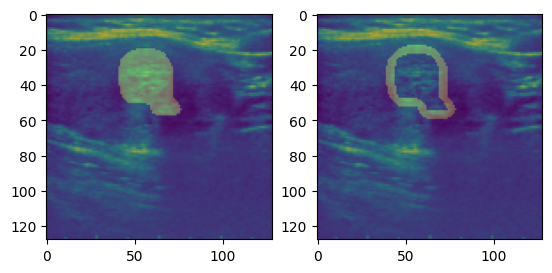

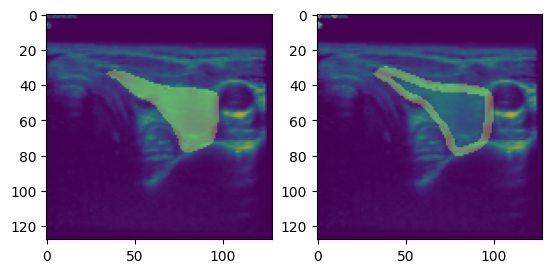

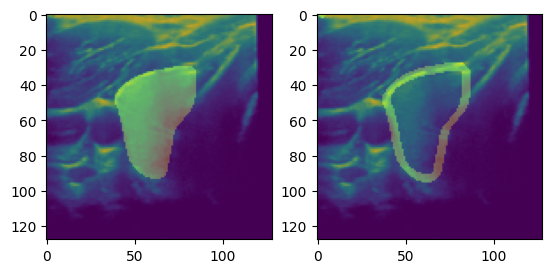

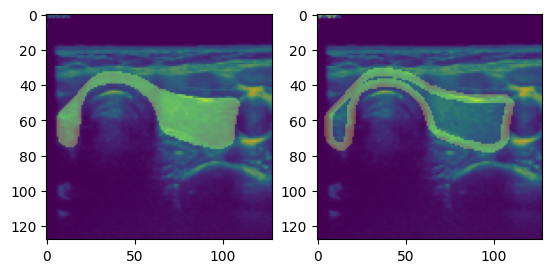

In [7]:
index = 39
for index in range(5):
    plt.subplot(1,2,1)
    # plt.imshow(mask[index][0], alpha = 0.3)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.3)
    
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(contour[index][0], alpha = 0.3)
    plt.show()

In [8]:
def average_mask_contour(mask_preds, contour_preds, weight_mask=0.7, threshold=0.5):
    prob_mask = torch.sigmoid(mask_preds)
    prob_contour = torch.sigmoid(contour_preds)

    combined = weight_mask * prob_mask + (1 - weight_mask) * prob_contour
    return (combined > threshold).float()  # shape: (B, 1, H, W)

In [9]:
def train(dataloader, model, optimizer, image_loss_fn_nodule, image_loss_fn_gland, contour_loss_fn_nodule, contour_loss_fn_gland, device, epoch, name = "test"):
    image_total_loss = 0
    contour_total_loss = 0
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, contour, seg_type in tqdm(dataloader):
        image, mask, contour, seg_type = image.to(device), mask.to(device), contour.to(device), seg_type.to(device)
        
        image_pred, contour_pred = model(image)

        nodule_image_pred = image_pred[:, 0:1][seg_type==1]
        gland_image_pred = image_pred[:, 1:2][seg_type==2]
        nodule_image_mask = mask[seg_type==1]
        gland_image_mask = mask[seg_type==2]
    
        nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]
        gland_contour_pred = contour_pred[:, 1:2][seg_type==2]
        nodule_contour_mask = contour[seg_type==1]
        gland_contour_mask = contour[seg_type==2]

        # get loss
        nodule_image_loss = image_loss_fn_nodule(nodule_image_pred, nodule_image_mask)
        gland_image_loss = image_loss_fn_gland(gland_image_pred, gland_image_mask)
        
        nodule_contour_loss = contour_loss_fn_nodule(nodule_contour_pred, nodule_contour_mask)
        gland_contour_loss = contour_loss_fn_gland(gland_contour_pred, gland_contour_mask)

        
        image_loss = nodule_image_loss + gland_image_loss
        contour_loss = nodule_contour_loss + gland_contour_loss
        if epoch < 100:
            loss = contour_loss * 2
        else:
            loss = image_loss + contour_loss


        # get IOU
        nodule_image_IOU = IOU_score(nodule_image_pred, nodule_image_mask)
        gland_image_IOU = IOU_score(gland_image_pred, gland_image_mask)
        
        IOU = (nodule_image_IOU + gland_image_IOU) / 2

        # get DICE
        dice_loss = DiceLoss()
    
        nodule_image_DICE = 1 - dice_loss(nodule_image_pred, nodule_image_mask)
        gland_image_DICE = 1 - dice_loss(gland_image_pred, gland_image_mask)
        
        DICE = (nodule_image_DICE + gland_image_DICE) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        image_total_loss += image_loss.item()
        contour_total_loss += contour_loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

    nodule_image_show = torch.sigmoid(nodule_image_pred)
    nodule_image_show = (nodule_image_show > 0.5)
    nodule_contour_show = torch.sigmoid(nodule_contour_pred)
    nodule_contour_show = (nodule_contour_show > 0.5)
    if epoch%5==0:
        save_2x2_comparison(nodule_contour_mask, nodule_contour_show, nodule_image_mask, nodule_image_show, save_path=f"./output_images/{name}/train/", filename=f"nodule_plot_{epoch}.png")
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), image_total_loss/len(dataloader), contour_total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, image_loss_fn_nodule, contour_loss_fn_nodule, device, epoch, name):
    total_loss = 0
    DDTI_image_total_loss = 0
    TN3K_image_total_loss = 0
    DDTI_contour_total_loss = 0
    TN3K_contour_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, contour, seg_type, from_dataset in tqdm(dataloader):
        image, mask, contour, seg_type = image.to(device), mask.to(device), contour.to(device), seg_type.to(device)
        image_pred, contour_pred = model(image)
                
        nodule_image_pred = image_pred[:, 0:1][seg_type==1]
        nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]

        nodule_image_mask = mask[seg_type==1]
        nodule_contour_mask = contour[seg_type==1]



        DDTI_nodule_image_output = nodule_image_pred[from_dataset==1]
        TN3K_nodule_image_output = nodule_image_pred[from_dataset==3]

        DDTI_nodule_image_mask = nodule_image_mask[from_dataset==1]
        TN3K_nodule_image_mask = nodule_image_mask[from_dataset==3]

        DDTI_nodule_contour_output = nodule_contour_pred[from_dataset==1]
        TN3K_nodule_contour_output = nodule_contour_pred[from_dataset==3]

        DDTI_nodule_contour_mask = nodule_contour_mask[from_dataset==1]
        TN3K_nodule_contour_mask = nodule_contour_mask[from_dataset==3]

        # get image loss
        DDTI_nodule_image_loss = image_loss_fn_nodule(DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_nodule_image_loss = image_loss_fn_nodule(TN3K_nodule_image_output, TN3K_nodule_image_mask)
        
        # get contour loss 
        DDTI_nodule_contour_loss = contour_loss_fn_nodule(DDTI_nodule_contour_output, DDTI_nodule_contour_mask)
        TN3K_nodule_contour_loss = contour_loss_fn_nodule(TN3K_nodule_contour_output, TN3K_nodule_contour_mask)


        nodule_loss = DDTI_nodule_image_loss + TN3K_nodule_image_loss + DDTI_nodule_contour_loss + TN3K_nodule_contour_loss
    
        # do post-process with contour and mask
        sig_DDTI_nodule_image_output = torch.sigmoid(DDTI_nodule_image_output)
        sig_DDTI_nodule_contour_output = torch.sigmoid(DDTI_nodule_contour_output)
        refined_DDTI_nodule_image_output = average_mask_contour(sig_DDTI_nodule_image_output, sig_DDTI_nodule_contour_output)

        sig_TN3K_nodule_image_output = torch.sigmoid(TN3K_nodule_image_output)
        sig_TN3K_nodule_contour_output = torch.sigmoid(TN3K_nodule_contour_output)
        refined_TN3K_nodule_image_output = average_mask_contour(sig_TN3K_nodule_image_output, sig_TN3K_nodule_contour_output)
        
        # get IOU
        DDTI_IOU = IOU_score(refined_DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_IOU = IOU_score(refined_TN3K_nodule_image_output, TN3K_nodule_image_mask)

        IOU = (DDTI_IOU + TN3K_IOU) / 2

        # get DICE
        dice_loss = DiceLoss()
        DDTI_DICE = 1 - dice_loss(refined_DDTI_nodule_image_output, DDTI_nodule_image_mask)
        TN3K_DICE = 1 - dice_loss(refined_TN3K_nodule_image_output, TN3K_nodule_image_mask)

        DICE = (DDTI_DICE + TN3K_DICE) / 2
        

        total_loss += nodule_loss.item()
        DDTI_image_total_loss += DDTI_nodule_image_loss.item()
        TN3K_image_total_loss += TN3K_nodule_image_loss.item()
        DDTI_contour_total_loss += DDTI_nodule_contour_loss.item()
        TN3K_contour_total_loss += TN3K_nodule_contour_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    nodule_image_show = torch.sigmoid(nodule_image_pred)
    nodule_image_show = (nodule_image_show > 0.5)
    nodule_contour_show = torch.sigmoid(nodule_contour_pred)
    nodule_contour_show = (nodule_contour_show > 0.5)
    if epoch%5==0:
        save_2x2_comparison(nodule_contour_mask, nodule_contour_show, nodule_image_mask, nodule_image_show, save_path=f"./output_images/{name}/test/", filename=f"nodule_plot_{epoch}.png")
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_image_total_loss/len(dataloader), DDTI_contour_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_image_total_loss/len(dataloader), TN3K_contour_total_loss/len(dataloader),TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 




    

In [10]:
epochs = 200
lr = 0.01
project = "thyroid_hybrid_contour_model"
# name=name="PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_hflip(0.5)_lr_0.001"
# name = "HarDnet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
# name = "LightMed_crop_DDTI"
# name = "test"
# name = "HarDnetMSEG_baseline"
# name = "hybrid_v4_baseline"
name = "hybrid_v3_contour_baselinee"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
model =  HybridSegModel_contour(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)

In [12]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}, model : {model}")

image size : 128, lr : 0.01, epochs : 200, batch size : 128, model : HybridSegModel_contour(
  (backbone): HarDNetBackbone(
    (base_conv_1): ConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (hardblock): HarDBlock(
          (layers): ModuleList(
            (0): ConvLayer(
              (conv): Conv2d(64, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (nor

### If using pretrained model

In [13]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [14]:
# loss_fn = DiceLoss()
image_loss_fn_nodule = StructureLoss()
image_loss_fn_gland = StructureLoss()

contour_loss_fn_nodule = DiceLoss()
contour_loss_fn_gland = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, image_total_loss_train, contour_total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, image_loss_fn_nodule, image_loss_fn_gland, contour_loss_fn_nodule, contour_loss_fn_gland, "cuda", epoch, name)
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_image_total_loss_val, DDTI_contour_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_image_total_loss_val, TN3K_contour_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, image_loss_fn_nodule, contour_loss_fn_gland, "cuda", epoch, name)
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "image_train_loss": image_total_loss_train,
        "contour_train_loss": contour_total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_image_val_loss": DDTI_image_total_loss_val,
        "DDTI_contour_val_loss": DDTI_contour_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_image_val_loss": TN3K_image_total_loss_val,
        "TN3K_contour_val_loss": TN3K_contour_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 51/51 [00:24<00:00,  2.07it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_0.png
train loss : 3.3291724756652235, train IOU : 0.20968936880429587, train DICE : 0.3308902201699276


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_0.png
val loss : 6.0339148998260494, val IOU : 0.167226904630661, val DICE : 0.27133998572826384
epoch : 1


100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


train loss : 2.948581849827486, train IOU : 0.22874875016072216, train DICE : 0.36691754705765667


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


val loss : 5.566873264312744, val IOU : 0.16722721755504608, val DICE : 0.2713402837514877
epoch : 2


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 2.702026694428687, train IOU : 0.28785880640441297, train DICE : 0.4423879110345654


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 5.215489721298217, val IOU : 0.16748058497905732, val DICE : 0.2714806258678436
epoch : 3


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train loss : 2.286429854000316, train IOU : 0.3083381620692272, train DICE : 0.46332626249275954


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 8.504964542388915, val IOU : 0.20055707842111586, val DICE : 0.28083356022834777
epoch : 4


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.9095674566194123, train IOU : 0.2519101591086855, train DICE : 0.3843736964113572


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


val loss : 9.507957458496094, val IOU : 0.24204205721616745, val DICE : 0.2843735307455063
epoch : 5


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_5.png
train loss : 1.7544177466747808, train IOU : 0.256242188168507, train DICE : 0.38010714918959376


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_5.png
val loss : 10.680054473876954, val IOU : 0.19657305777072906, val DICE : 0.2755338460206985
epoch : 6


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.6314852845435048, train IOU : 0.28449613674014224, train DICE : 0.41326452002805825


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


val loss : 10.300729751586914, val IOU : 0.18812859505414964, val DICE : 0.2752818435430527
epoch : 7


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.546328392683291, train IOU : 0.30321065409510745, train DICE : 0.43173324594310686


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 12.263942337036132, val IOU : 0.15414799004793167, val DICE : 0.26783145368099215
epoch : 8


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.4911124145283419, train IOU : 0.31438929076288263, train DICE : 0.44255537729637295


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


val loss : 11.347869777679444, val IOU : 0.2106045350432396, val DICE : 0.27450198829174044
epoch : 9


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.4185745809592454, train IOU : 0.3237315065720502, train DICE : 0.4499849110257392


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


val loss : 12.313544464111327, val IOU : 0.1845467731356621, val DICE : 0.27067388594150543
epoch : 10


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_10.png
train loss : 1.3529293233273076, train IOU : 0.3422100812781091, train DICE : 0.4662153159870821


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_10.png
val loss : 12.179990673065186, val IOU : 0.17312032729387283, val DICE : 0.2699143350124359
epoch : 11


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train loss : 1.3744526587280572, train IOU : 0.34240160911690953, train DICE : 0.46575023555288125


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 13.701368141174317, val IOU : 0.1845641851425171, val DICE : 0.27125649750232694
epoch : 12


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train loss : 1.481852655317269, train IOU : 0.2080796422327266, train DICE : 0.31255047929053215


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


val loss : 16.11736469268799, val IOU : 0.20608711540699004, val DICE : 0.27183230221271515
epoch : 13


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.3278736717560713, train IOU : 0.20000431701248766, train DICE : 0.2948070752854441


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


val loss : 17.22901859283447, val IOU : 0.19565870761871337, val DICE : 0.27000775635242463
epoch : 14


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.267796703413421, train IOU : 0.20169398393116744, train DICE : 0.2974483709709317


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


val loss : 18.33109817504883, val IOU : 0.20572099089622498, val DICE : 0.27044677138328554
epoch : 15


100%|██████████| 51/51 [00:19<00:00,  2.56it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_15.png
train loss : 1.2225146854625029, train IOU : 0.203280362720583, train DICE : 0.2977749822186489


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_15.png
val loss : 18.76283702850342, val IOU : 0.1973812222480774, val DICE : 0.27025793492794037
epoch : 16


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.1775579639509612, train IOU : 0.20471265765966154, train DICE : 0.29824653384732264


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


val loss : 19.20362091064453, val IOU : 0.18931829631328584, val DICE : 0.2681480944156647
epoch : 17


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train loss : 1.1534262264476103, train IOU : 0.20522715034438113, train DICE : 0.29846357130536844


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 20.84180145263672, val IOU : 0.20662926882505417, val DICE : 0.26963583528995516
epoch : 18


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.1358567710016287, train IOU : 0.2063328226407369, train DICE : 0.3002014171843435


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 22.84016342163086, val IOU : 0.20879001915454865, val DICE : 0.26977562308311465
epoch : 19


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.0819345852907967, train IOU : 0.20860774406031066, train DICE : 0.3017155861153322


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 24.869387817382812, val IOU : 0.15632060766220093, val DICE : 0.26375678181648254
epoch : 20


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_20.png
train loss : 1.065011234844432, train IOU : 0.20812289884277418, train DICE : 0.3007888425798977


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_20.png
val loss : 23.47082691192627, val IOU : 0.17672820389270782, val DICE : 0.26633653342723845
epoch : 21


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 1.0380245821148741, train IOU : 0.2092814664630329, train DICE : 0.30134616879855886


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 23.533252143859862, val IOU : 0.1940033882856369, val DICE : 0.2688405901193619
epoch : 22


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.9944368250229779, train IOU : 0.2093223850516712, train DICE : 0.30203429448838326


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 25.455860710144044, val IOU : 0.19927831888198852, val DICE : 0.26829812228679656
epoch : 23


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train loss : 0.9643538372189391, train IOU : 0.20944273764011906, train DICE : 0.30100658886572895


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


val loss : 26.213215827941895, val IOU : 0.18849574476480485, val DICE : 0.26692226231098176
epoch : 24


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.9613392937417123, train IOU : 0.21090025586240432, train DICE : 0.3021516285690607


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 25.164487075805663, val IOU : 0.20237698704004287, val DICE : 0.26992403268814086
epoch : 25


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_25.png
train loss : 0.9430736069585762, train IOU : 0.21191098058924956, train DICE : 0.3032882944041607


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_25.png
val loss : 24.0100341796875, val IOU : 0.22465923428535461, val DICE : 0.2721709370613098
epoch : 26


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.9107324445948881, train IOU : 0.21241016393783047, train DICE : 0.3036370481930527


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


val loss : 29.155686378479004, val IOU : 0.18344906121492385, val DICE : 0.2667834460735321
epoch : 27


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.8748692741581038, train IOU : 0.21327413793872385, train DICE : 0.3040218844133265


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 27.677574920654298, val IOU : 0.21481148898601532, val DICE : 0.26998265981674197
epoch : 28


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.8463332208932615, train IOU : 0.21374119730556712, train DICE : 0.3040323777526033


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 29.911488723754882, val IOU : 0.19737426638603212, val DICE : 0.2679773449897766
epoch : 29


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.8326966739168354, train IOU : 0.21505065437625437, train DICE : 0.30552708518271354


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


val loss : 31.74161491394043, val IOU : 0.18206483721733094, val DICE : 0.26557348668575287
epoch : 30


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_30.png
train loss : 0.8094309077543371, train IOU : 0.21366060101518444, train DICE : 0.3045187650942335


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_30.png
val loss : 30.663446807861327, val IOU : 0.21992063373327256, val DICE : 0.2696121662855148
epoch : 31


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train loss : 0.7977323602227604, train IOU : 0.2163988366430881, train DICE : 0.30584944696987376


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 31.765877532958985, val IOU : 0.19490450769662857, val DICE : 0.2676487475633621
epoch : 32


100%|██████████| 51/51 [00:19<00:00,  2.56it/s]


train loss : 0.78079606738745, train IOU : 0.21772867441177368, train DICE : 0.307705176227233


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 34.04019432067871, val IOU : 0.19764158129692078, val DICE : 0.26730939745903015
epoch : 33


100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


train loss : 0.7676319795496324, train IOU : 0.2182985684450935, train DICE : 0.3075777759738997


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 31.57682991027832, val IOU : 0.2318372592329979, val DICE : 0.2705920547246933
epoch : 34


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.7483302962546255, train IOU : 0.21886282837858387, train DICE : 0.3080229297572491


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


val loss : 33.51228485107422, val IOU : 0.21628155559301376, val DICE : 0.26848297715187075
epoch : 35


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_35.png
train loss : 0.722886931662466, train IOU : 0.2189069174084009, train DICE : 0.30815425515174866


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_35.png
val loss : 35.268578147888185, val IOU : 0.20384088009595872, val DICE : 0.26775340735912323
epoch : 36


100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


train loss : 0.7109470040190453, train IOU : 0.22079849915177213, train DICE : 0.3097175143513025


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 34.036935043334964, val IOU : 0.207108835875988, val DICE : 0.268150606751442
epoch : 37


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.6915005796095904, train IOU : 0.2202045458788965, train DICE : 0.30909351800002305


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


val loss : 36.01119842529297, val IOU : 0.19296597838401794, val DICE : 0.2664866268634796
epoch : 38


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.6729064501968085, train IOU : 0.2220489312620724, train DICE : 0.3098928010931202


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 36.45925941467285, val IOU : 0.2009186789393425, val DICE : 0.267192417383194
epoch : 39


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


train loss : 0.6643364943710028, train IOU : 0.2229812189060099, train DICE : 0.31061660074720193


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 35.84325466156006, val IOU : 0.18864727765321732, val DICE : 0.26639039516448976
epoch : 40


100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_40.png
train loss : 0.6465210750991223, train IOU : 0.2229444627083984, train DICE : 0.3108031510138044


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_40.png
val loss : 38.844227981567386, val IOU : 0.19500839859247207, val DICE : 0.2669635772705078
epoch : 41


100%|██████████| 51/51 [00:19<00:00,  2.56it/s]


train loss : 0.6232354243596395, train IOU : 0.22293573676371106, train DICE : 0.31066689012097376


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


val loss : 39.1141544342041, val IOU : 0.21522862315177918, val DICE : 0.2682361721992493
epoch : 42


100%|██████████| 51/51 [00:21<00:00,  2.36it/s]


train loss : 0.6075555904238832, train IOU : 0.22465968950122012, train DICE : 0.31204727058317144


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


val loss : 38.15360374450684, val IOU : 0.2031726732850075, val DICE : 0.26756706535816194
epoch : 43


100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


train loss : 0.5974973884283328, train IOU : 0.22482910138719223, train DICE : 0.31225571211646586


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


val loss : 40.249726104736325, val IOU : 0.20163877308368683, val DICE : 0.26706990897655486
epoch : 44


100%|██████████| 51/51 [00:24<00:00,  2.04it/s]


train loss : 0.5902406351239073, train IOU : 0.22710306767155142, train DICE : 0.31344105566249175


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


val loss : 41.34886360168457, val IOU : 0.20018235743045806, val DICE : 0.2663092970848083
epoch : 45


100%|██████████| 51/51 [00:25<00:00,  2.00it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_45.png
train loss : 0.5760498748106115, train IOU : 0.2270618002204334, train DICE : 0.31389794513291003


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_45.png
val loss : 42.51210594177246, val IOU : 0.2034006670117378, val DICE : 0.26728705763816835
epoch : 46


100%|██████████| 51/51 [00:24<00:00,  2.09it/s]


train loss : 0.5689709280051437, train IOU : 0.22871305954222584, train DICE : 0.31493399715891074


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


val loss : 40.12752914428711, val IOU : 0.2172259047627449, val DICE : 0.2681306630373001
epoch : 47


100%|██████████| 51/51 [00:25<00:00,  2.04it/s]


train loss : 0.5581723568486232, train IOU : 0.22898070426548228, train DICE : 0.3154476296667959


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


val loss : 43.60412368774414, val IOU : 0.18908608704805374, val DICE : 0.2658997684717178
epoch : 48


100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


train loss : 0.5463775887208826, train IOU : 0.2296474856488845, train DICE : 0.3163694248479955


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val loss : 42.8228515625, val IOU : 0.20510556995868684, val DICE : 0.2673548012971878
epoch : 49


100%|██████████| 51/51 [00:24<00:00,  2.05it/s]


train loss : 0.5404841525881898, train IOU : 0.22977740507499844, train DICE : 0.3162573464945251


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


val loss : 44.55660514831543, val IOU : 0.1930333659052849, val DICE : 0.26582654416561124
epoch : 50


100%|██████████| 51/51 [00:20<00:00,  2.48it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/train/nodule_plot_50.png
train loss : 0.5353470316120222, train IOU : 0.23148112378868402, train DICE : 0.31725168403457193


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Saved to ./output_images/hybrid_v3_contour_baselinee/test/nodule_plot_50.png
val loss : 41.77514228820801, val IOU : 0.20877367854118348, val DICE : 0.2680635631084442
epoch : 51


100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


train loss : 0.5252109882878322, train IOU : 0.2311172050003912, train DICE : 0.31721016998384516


 90%|█████████ | 9/10 [00:03<00:00,  2.63it/s]

In [ ]:
print(max_IOU)